In [1]:
import matplotlib.pyplot as plt
import numpy as np
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.arima_model import ARIMA

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
def plot_series(time, series, format="-", start=0, end=None, label=None, show=True):
    plt.figure()
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)
    if show:
        plt.show()

In [3]:
time = np.arange(4 * 365 + 1)

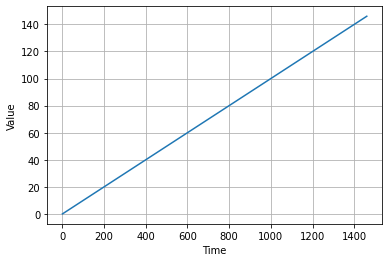

In [4]:
def trend(time, slope=0):
    return slope * time

series = trend(time, 0.1)
plot_series(time, series)

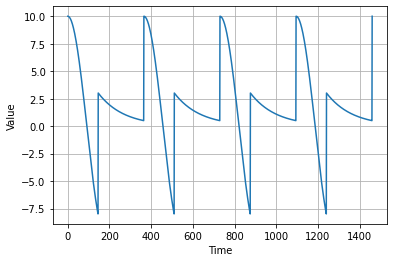

In [5]:
def seasonal_pattern(season_time):
    return np.where(season_time < 0.4, np.cos(season_time * 2 * np.pi), 1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

series = seasonality(time, period=365, amplitude=10)
plot_series(time, series)

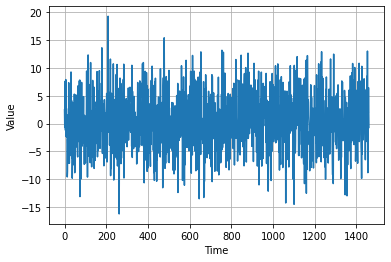

In [6]:
def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

noise = white_noise(time, noise_level=5, seed=42)
plot_series(time, noise)

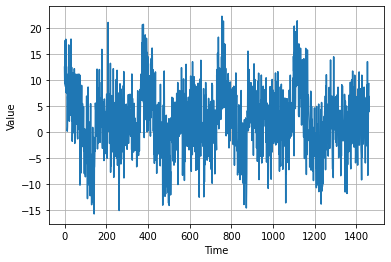

In [7]:
series += noise
plot_series(time, series)

In [8]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_val = time[split_time:]
x_val = series[split_time:]

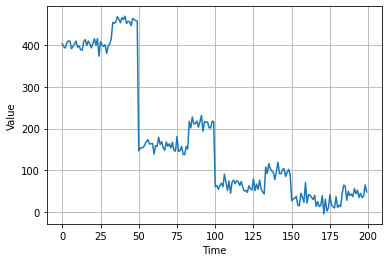

In [9]:
def autocorrelation_1(time, amplitude, seed=None):
    rnd = np.random.RandomState(seed)
    phi_1 = 0.5
    phi_2 = -0.1
    ar = rnd.randn(len(time) + 50)
    ar[:50] = 100
    for step in range(50, len(time) + 50):
        ar[step] += phi_1 * ar[step - 50]
        ar[step] += phi_2 * ar[step - 33]
    return ar[50:] * amplitude

series = autocorrelation_1(time, 10, seed=42)
plot_series(time, series, end=200)

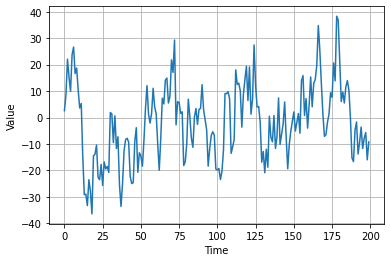

In [10]:
def autocorrelation_2(time, amplitude, seed=None):
    rnd = np.random.RandomState(seed)
    phi = 0.8
    ar = rnd.randn(len(time) + 1)
    for step in range(1, len(time) + 1):
        ar[step] += phi * ar[step - 1]
    return ar[1:] * amplitude

series = autocorrelation_2(time, 10, seed=42)
plot_series(time, series, end=200)

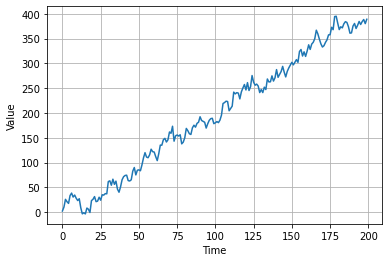

In [11]:
series = autocorrelation_2(time, 10, seed=42) + trend(time, 2)
plot_series(time, series, end=200)

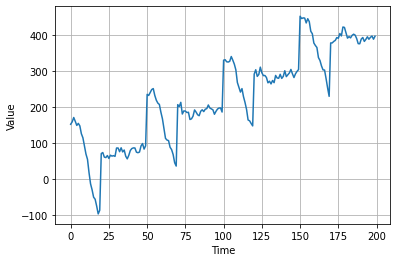

In [12]:
series = autocorrelation_2(time, 10, seed=42) + seasonality(time, period=50, amplitude=150) + trend(time, 2)
plot_series(time, series, end=200)

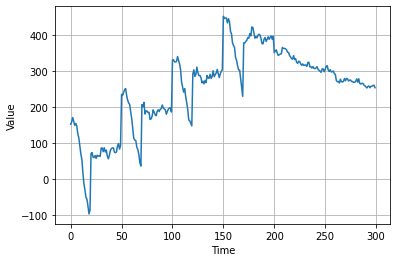

In [13]:
series = autocorrelation_2(time, 10, seed=42) + seasonality(time, period=50, amplitude=150) + trend(time, 2)
series_2 = autocorrelation_2(time, 5, seed=42) + seasonality(time, period=50, amplitude=2) + trend(time, -1) + 550
series[200:] = series_2[200:]
#series += noise(time, 30)
plot_series(time, series, end=300)

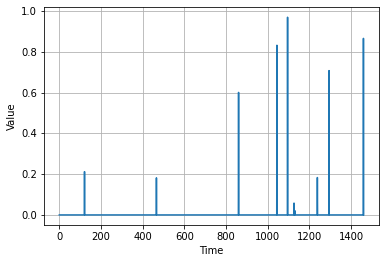

In [14]:
def impulses(time, num_impulses, amplitude=1, seed=None):
    rnd = np.random.RandomState(seed)
    impulse_indices = rnd.randint(len(time), size=10)
    series = np.zeros(len(time))
    for index in impulse_indices:
        series[index] += rnd.rand() * amplitude
    return series

series = impulses(time, 10, seed=42)
plot_series(time, series)

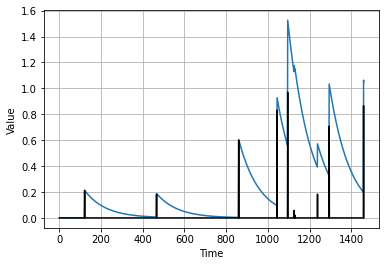

In [15]:
def autocorrelation(source, phi_s):
    ar = source.copy()
    max_lag = len(phi_s)
    for step, value in enumerate(source):
        for lag, phi in phi_s.items():
            if step - lag > 0:
              ar[step] += phi * ar[step - lag]
    return ar

signal = impulses(time, 10, seed=42)
series = autocorrelation(signal, {1: 0.99})
plot_series(time, series,  show=False)
plt.plot(time, signal, "k-")
plt.show()

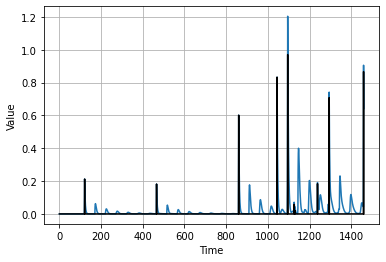

In [16]:
signal = impulses(time, 10, seed=42)
series = autocorrelation(signal, {1: 0.70, 50: 0.2})
plot_series(time, series, show=False)
plt.plot(time, signal, 'k-')
plt.show()

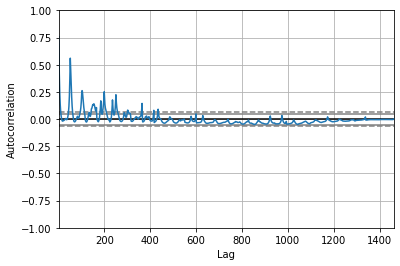

In [17]:
autocorrelation_plot(series)

In [18]:
model = ARIMA(series, order=(5, 1, 0))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                 1460
Model:                 ARIMA(5, 1, 0)   Log Likelihood                2223.428
Method:                       css-mle   S.D. of innovations              0.053
Date:                Tue, 17 Nov 2020   AIC                          -4432.855
Time:                        06:55:49   BIC                          -4395.852
Sample:                             1   HQIC                         -4419.052
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.001      0.384      0.701      -0.001       0.002
ar.L1.D.y     -0.1235      0.026     -4.714      0.000      -0.175      -0.072
ar.L2.D.y     -0.1254      0.029     -4.333      0.0